DB OK: 2026-01-21 16:47:26.064872+00:00

Топ-5 игроков по очкам:


,name,total_points
0,Stan,134797
1,Chef,129718
2,Mr. Garrison,128699
3,Butters,125282
4,Cartman,125144



Средний PvP-рейтинг по гильдиям:


,guild,avg_pvp_rating
0,Kirin Tor,1786.0
1,The Horde,1781.0
2,Shadow Council,1720.0
3,Silver Hand,1674.0
4,Warsong Clan,1330.5
5,Alliance Vanguard,1107.0



Добыча предметов по редкости:


,item_rarity,loot_count
0,Common,1119
1,Rare,786
2,Epic,111


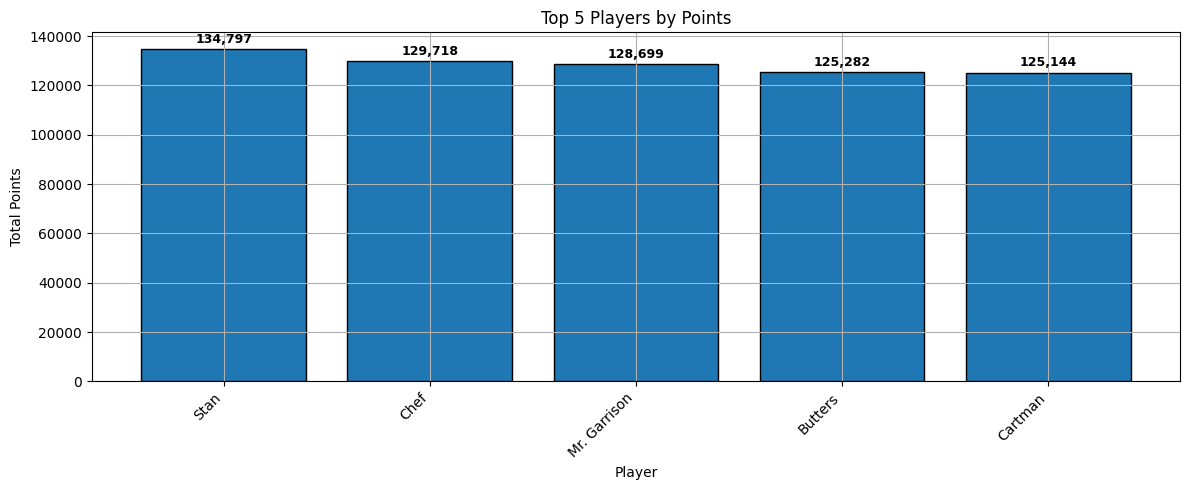

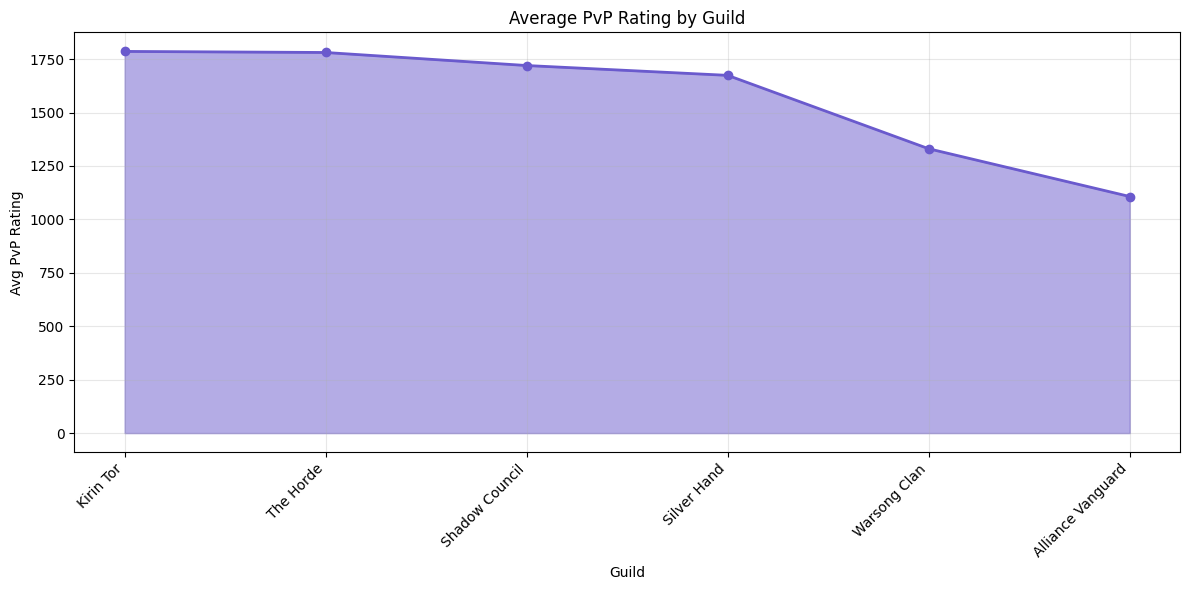

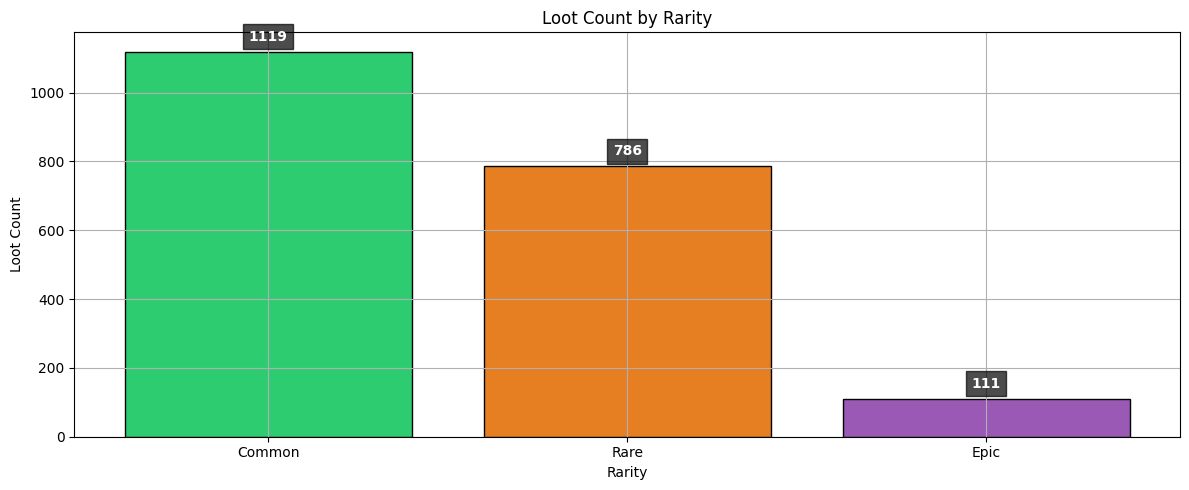

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

load_dotenv()

DB_HOST = os.getenv("DB_HOST", "postgres")
DB_PORT = os.getenv("DB_PORT", "5432")
DB_NAME = os.getenv("POSTGRESQL_DATABASE", "main_db") 
DB_USER = os.getenv("POSTGRESQL_USERNAME", "wow_user")  
DB_PASS = os.getenv("POSTGRESQL_PASSWORD", "wow_pass") 

dsn = f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(dsn)

with engine.connect() as conn:
    print("DB OK:", conn.exec_driver_sql("SELECT now()").scalar())

query_top_players = """
SELECT 
    p.name,
    SUM(ge.points) AS total_points
FROM game_events ge
JOIN players p ON ge.player_id = p.id
GROUP BY p.name
ORDER BY total_points DESC
LIMIT 5;
"""

query_guild_pvp = """
SELECT 
    guild,
    ROUND(AVG(pvp_rating), 2) AS avg_pvp_rating
FROM players
WHERE guild IS NOT NULL
GROUP BY guild
ORDER BY avg_pvp_rating DESC;
"""

query_loot_rarity = """
SELECT 
    item_rarity,
    COUNT(*) AS loot_count
FROM game_events
WHERE item_rarity IS NOT NULL
GROUP BY item_rarity
ORDER BY 
    CASE item_rarity
        WHEN 'Common' THEN 1
        WHEN 'Rare' THEN 2
        WHEN 'Epic' THEN 3
    END;
"""

df_top = pd.read_sql(query_top_players, engine)
df_guild = pd.read_sql(query_guild_pvp, engine)
df_loot = pd.read_sql(query_loot_rarity, engine)

print("\nТоп-5 игроков по очкам:")
display(df_top)

print("\nСредний PvP-рейтинг по гильдиям:")
display(df_guild)

print("\nДобыча предметов по редкости:")
display(df_loot)


plt.figure()
bars = plt.bar(df_top['name'], df_top['total_points'], color='#1f77b4', edgecolor='black')
plt.title('Top 5 Players by Points')
plt.xlabel('Player')
plt.ylabel('Total Points')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + df_top['total_points'].max()*0.01,
             f'{int(h):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.fill_between(df_guild['guild'], df_guild['avg_pvp_rating'], color='#6a5acd', alpha=0.5)
plt.plot(df_guild['guild'], df_guild['avg_pvp_rating'], color='#6a5acd', marker='o', linewidth=2)
plt.title('Average PvP Rating by Guild')
plt.xlabel('Guild')
plt.ylabel('Avg PvP Rating')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure()
colors = ['#2ecc71', '#e67e22', '#9b59b6']
bars = plt.bar(df_loot['item_rarity'], df_loot['loot_count'], color=colors, edgecolor='black')
plt.title('Loot Count by Rarity')
plt.xlabel('Rarity')
plt.ylabel('Loot Count')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + df_loot['loot_count'].max()*0.02,
             str(int(h)), ha='center', va='bottom', fontsize=10, fontweight='bold',
             color='white', bbox=dict(facecolor='black', alpha=0.7))
plt.tight_layout()
plt.show()